In [ ]:
# Copyright 2023 Regeneron Pharmaceuticals Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [50]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import entropy
import pickle
import os
import json

from tcrvalid.load_models import *
from tcrvalid.plot_utils import set_simple_rc_params
from tcrvalid.physio_embedding import SeqArrayDictConverter
from tcrvalid.defaults import *

from hinton import hinton

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
sns.set(context='talk',palette='bright')
set_simple_rc_params()

### Load pre-calculated feature importance scores for all models

 - We applied random forest (RF) to classify/regress v,J and insert-region phycisochemcial properties from the model latent space representations
   - an example of how this is done is shown in "hinton_feature_importance_example.ipynb" 
 - Due to the time to fit these RF models we here use a pre-saved dataset of the feature importances for each model
 - these features are not co-packed with the main tcrvalid package, and so the path below to save features must be relative or absolute path to where the 'results_data' directory is on your machine.
 
### Use feature importances to make Hinton diagrams of the importances

In [2]:
# data pre-computed feature importances for each generative factor for each model : dataframe
imps_df = pd.read_pickle('../results_data/importances.pkl') 

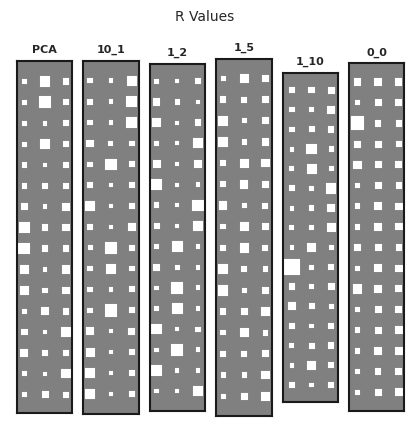

In [3]:
plt.figure(figsize=(5, 5))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("R Values", fontsize=10, y=0.95)
model=['PCA','10_1','1_2','1_5','1_10','0_0']

# loop through the length of tickers and keep track of index

for n,ticker in enumerate(model):
    # importance distionary to numpy array
    temp=np.array([imps_df[ticker]['Mean_Physio'],imps_df[ticker]['new_meta_vcall'],imps_df[ticker]['j_call']])

    # add a new subplot iteratively
    ax = plt.subplot(1, 6, n + 1)
    hinton(temp,max_weight=1)
    ax.set_title(ticker.upper())

### Calculate the disentanglment score for each model's feature importances

 - each of the Hinton diagrams above show the model feature importances:
     - columns are for each of the threee generative factors
     - rows are the 16 latent dimensions
     
 - The method of Eastwood and Williams can be used to score the level of disentanglement of each model
 - We can further compare this with the reconstruction ability of the model
 - Higher model capacities lead to more accurate model reconstructions, but at the cost of a less smooth latent space, and reduced feature disentanglement

In [4]:
def entropy_hm(x):
    base = len(x)
    return -np.sum( x*(np.log(x)/np.log(base)) )

In [5]:
def disentanglement_score(importances):
    """ scores disentanglement via Eastwood and Williams method
    
    parameters
    ----------
    importances: np.array
        array of feature importances (n_dimensions, n_generative_features)
    
    returns
    --------
    score: float
        The score
    """
    probs_by_feature = (np.array(importances/[np.sum(importances,axis=1)[:,None]]))[0]
    rho = np.sum(importances,axis=1)/np.sum(importances)
    n_dims = importances.shape[0]
    D=np.empty([n_dims])
    for i in range(n_dims):
        D[i]=np.array((1-entropy_hm(probs_by_feature[i])))
    score = np.sum(rho*D)
    return score

In [6]:
model=['PCA','10_1','1_2','1_5','1_10','0_0']
scores = dict()
for k in model:
    importances = np.array([imps_df[k]['Mean_Physio'],imps_df[k]['new_meta_vcall'],imps_df[k]['j_call']]).T
    scores[k] = disentanglement_score(importances)

In [7]:
scores

{'PCA': 0.21644560409823677,
 '10_1': 0.3351680566061882,
 '1_2': 0.4663063029824277,
 '1_5': 0.1657190994171867,
 '1_10': 0.29107467150734967,
 '0_0': 0.09465808340563846}

In [8]:
# collect reconstruction loss for models from the model metadata
recon_losses = dict()
for m in ['10_1','1_2','1_5','1_10','0_0']:
    metrics_path = os.path.join(
        keras_model_base_path,
        'TRB',
        m,
        'metrics.json'
    )
    with open(metrics_path, 'r') as f:
        l = json.load(f)['val_reconstruction_loss']
    recon_losses[m] = l
print(recon_losses)

{'10_1': 14.2749605178833, '1_2': 1.376659631729126, '1_5': 0.37203919887542725, '1_10': 0.37576740980148315, '0_0': 0.3878520727157593}


Note: Reconstruction loss for PCA currently hardcoded as computed on larger train and validation dataset used for training the TCR-VALID models. Example of how PCA reconstruction loss is computed in included in PCA reconstruction loss notebook.

In [9]:
recon_losses['PCA']=34.86112144

In [37]:

plot_df=pd.DataFrame({'Disintangling Score':pd.Series(scores),'Reconstruction loss':pd.Series(recon_losses)})
plot_df=plot_df2.reindex(['PCA','10_1','1_2','1_5','1_10','0_0'])
plot_df['Capacity']=[0,1,2,3,4,5]


In [38]:
plot_df

,Disintangling Score,Reconstruction loss,Capacity
PCA,0.216446,34.860000,0
10_1,0.335168,14.274961,1
1_2,0.466306,1.376660,2
1_5,0.165719,0.372039,3
1_10,0.291075,0.375767,4
0_0,0.094658,0.387852,5


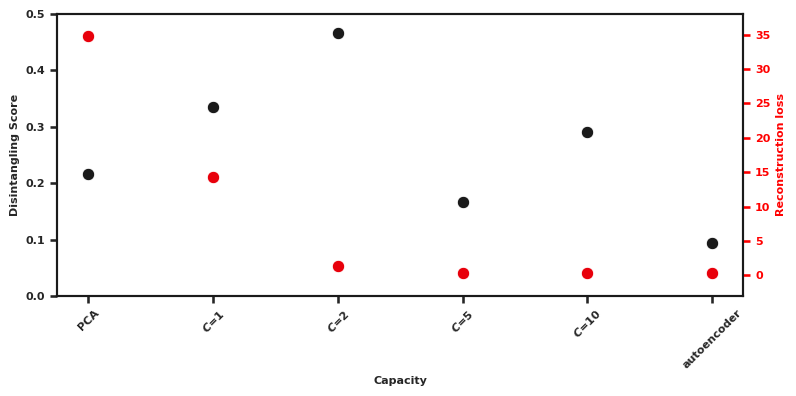

In [55]:
f,axes=plt.subplots(1,1,figsize=(8,4))
ax=sns.scatterplot(
    data = plot_df,
    x='Capacity',
    color='k',
    y='Disintangling Score'
)
labels = ['PCA','$C$=1','$C$=2','$C$=5','$C$=10','autoencoder']
plt.xticks(plot_df['Capacity'], labels, rotation=45)
ax2 = plt.twinx()
ax2=sns.scatterplot(
    data = plot_df,
    x='Capacity',
    color='r',
    y='Reconstruction loss'
)
# ax.set_ylim([0,0.16])
ax.set_ylim([0,0.5])
ax2.set_ylim([-3,38])

ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')

plt.tight_layout()
#f.savefig('/data/home/allen.leary/tcrvalid_figs/Disintangling_vs_Reconloss.pdf',bbox_inches='tight')  
